<a href="https://colab.research.google.com/github/JavierArroyoBastida/project1-boptest/blob/issue345b_bestestHpExampleColab/examples/python/bestestHeatPump.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

General package import:

In [4]:
import sys
import pathlib
import requests
import numpy as np
import pandas as pd
from pprint import pformat
from matplotlib import pyplot as plt
import time

# Set URL for the BOPTEST service
url = 'http://ec2-23-20-252-119.compute-1.amazonaws.com'


TEST CASE NAME -----------------------------------------------
{'name': 'bestest_hydronic_heat_pump'}
TEST CASE INPUTS ---------------------------------------------
{'oveFan_activate': {'Description': 'Activation for Integer signal to control '
                                    'the heat pump evaporator fan either on or '
                                    'off',
                     'Maximum': None,
                     'Minimum': None,
                     'Unit': None},
 'oveFan_u': {'Description': 'Integer signal to control the heat pump '
                             'evaporator fan either on or off',
              'Maximum': 1,
              'Minimum': 0,
              'Unit': '1'},
 'oveHeaPumY_activate': {'Description': 'Activation for Heat pump modulating '
                                        'signal for compressor speed between 0 '
                                        '(not working) and 1 (working at '
                                        'maximum capacity)',
   

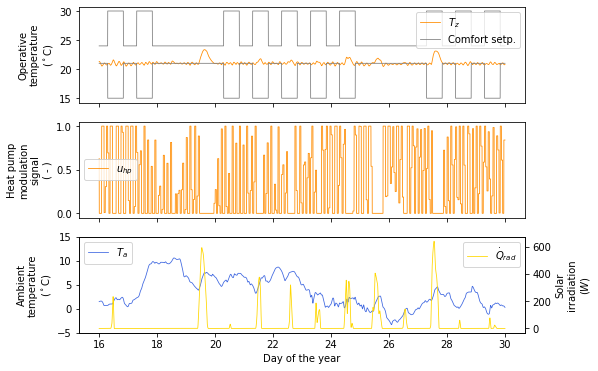

In [5]:

class Controller_Proportional(object):
    
    def __init__(self, TSet=273.15+21, k_p=10.):
        '''Constructor.

        Parameters
        ----------
        TSet : float, optional
            Temperature set-point.
        k_p : float, optional
            Proportionality constant. 
            
        '''
        
        self.TSet = TSet
        self.k_p  = k_p
    
    def compute_control(self, y):
        '''Compute the control input from the measurement.
    
        Parameters
        ----------
        y : dict
            Contains the current values of the measurements.
            {<measurement_name>:<measurement_value>}
    
        Returns
        -------
        u : dict
            Defines the control input to be used for the next step.
            {<input_name> : <input_value>}
    
        '''
    
        # Compute control
        if y['reaTZon_y']<self.TSet:
            e = self.TSet - y['reaTZon_y']
        else:
            e = 0
    
        value = self.k_p*e
        u = {'oveHeaPumY_u':value,
             'oveHeaPumY_activate': 1}
    
        return u

def get_and_plot_results(testid, start_time, final_time):
    
    df_res = pd.DataFrame()
    for point in ['reaTZon_y', 'reaTSetHea_y', 'reaTSetCoo_y', 'reaHeaPumY_y', 
                  'weaSta_reaWeaTDryBul_y', 'weaSta_reaWeaHDirNor_y']:
        # Retrieve full simlation year to ensure we get all data
        args = {'point_name':point,'start_time':start_time, 'final_time':final_time}
        res = requests.put('{0}/results/{1}'.format(url, testid), data=args).json()
        df_res = pd.concat((df_res,pd.DataFrame(data=res[point], index=res['time'],columns=[point])), axis=1)
    df_res.index.name = 'time'
    
    _, axs = plt.subplots(3, sharex=True, figsize=(8,6))
    x_time = df_res.index/3600./24.
    
    # Plot operative temperature
    axs[0].plot(x_time, df_res['reaTZon_y']    - 273.15, color='darkorange', linestyle='-', linewidth=0.8, label='$T_z$')
    axs[0].plot(x_time, df_res['reaTSetHea_y'] - 273.15, 'gray', linewidth=0.8, label='Comfort setp.')
    axs[0].plot(x_time, df_res['reaTSetCoo_y'] - 273.15, 'gray', linewidth=0.8, label='_nolegend_')
    axs[0].set_yticks(np.arange(15, 31, 5))
    axs[0].set_ylabel('Operative\ntemperature\n($^\circ$C)')
    axs[0].legend()
    # Plot heat pump modulation signal
    axs[1].plot(x_time, df_res['reaHeaPumY_y'],   color='darkorange',     linestyle='-', linewidth=0.8, label='$u_{hp}$')
    axs[1].set_ylabel('Heat pump\nmodulation\nsignal\n( - )')
    axs[1].legend()
    # Plot disturbances
    axs[2].plot(x_time, df_res['weaSta_reaWeaTDryBul_y'] - 273.15, color='royalblue', linestyle='-', linewidth=0.8, label='$T_a$')
    axs[2].set_ylabel('Ambient\ntemperature\n($^\circ$C)')
    axs[2].set_yticks(np.arange(-5, 16, 5))
    axs[2].legend(loc='upper left')
    axs[2].set_xlabel('Day of the year')
    axt = axs[2].twinx()
    axt.plot(x_time, df_res['weaSta_reaWeaHDirNor_y'], color='gold', linestyle='-', linewidth=0.8, label='$\dot{Q}_{rad}$')
    axt.set_ylabel('Solar\nirradiation\n($W$)')
    axt.legend(loc='upper right')
    plt.show()  

def run(plot=False):
    '''This is the main script.

    Parameters
    ----------
    plot : boolean
        True to plot result at end.
        Default is True.

    Returns
    -------
    kpi : dict
        Dictionary containing KPI values at end of test.

    '''

    # Instantiate controller 
    con = Controller_Proportional(TSet=273.15+21, k_p=5.)

    # Select test case and get identifier
    testcase = 'bestest_hydronic_heat_pump'
    testid = requests.post('{0}/testcases/{1}/select'.format(url,testcase)).json()['testid']

    # Set testing scenario
    scenario = {'time_period':'peak_heat_day', 'electricity_price':'dynamic'}

    # Get test case name
    name = requests.get('{0}/name/{1}'.format(url, testid)).json()
    print('TEST CASE NAME -----------------------------------------------')
    print(pformat(name))
    # Get inputs available
    inputs = requests.get('{0}/inputs/{1}'.format(url, testid)).json()
    print('TEST CASE INPUTS ---------------------------------------------')
    print(pformat(inputs))
    # Get measurements available
    print('TEST CASE MEASUREMENTS ---------------------------------------')
    measurements = requests.get('{0}/measurements/{1}'.format(url, testid)).json()
    print(pformat(measurements))
    
    # --------------------------------------------------------------------
    # RUN TEST CASE
    # --------------------------------------------------------------------
    
    # Set control step
    step = 3600
    requests.put('{0}/step/{1}'.format(url, testid), data={'step':step})
    
    # Set test case scenario
    y = requests.put('{0}/scenario/{1}'.format(url, testid), data=scenario).json()['time_period']
    
    # Record test start time
    start_time = y['time']
    
    # Simulation Loop
    while y:
        # Compute control signal
        u = con.compute_control(y)
        # Advance simulation with control signal
        print('Operative temperature  = {:.2f}'.format(y['reaTZon_y']-273.15))
        simulation_time = y['time']
        print('Simulation time (days) = {:.2f}'.format((simulation_time-start_time)/3600/24))
        print('----------------------------------------------------------')
        y = requests.post('{0}/advance/{1}'.format(url, testid), data=u).json()
        time.sleep(0.1)
    
    # Get KPIs
    kpi = requests.get('{0}/kpi/{1}'.format(url, testid)).json()
    print('\nKPI RESULTS \n-----------')
    for key in kpi.keys():
        if key == 'tdis_tot':
            unit = 'Kh/zone'
        if key == 'idis_tot':
            unit = 'ppmh/zone'
        elif key == 'ener_tot':
            unit = 'kWh/m^2'
        elif key == 'cost_tot':
            unit = 'EUR/m^2'
        elif key == 'emis_tot':
            unit = '(kg CO2)/m^2'
        elif key == 'time_rat':
            unit = ''
        print('{0}: {1} {2}'.format(key, kpi[key], unit))
    
    # Plot
    if plot:
        get_and_plot_results(testid, start_time, simulation_time)
        
    requests.put('{0}/stop/{1}'.format(url, testid))

    return kpi

if __name__ == "__main__":
    kpi = run(plot=True)